In [1]:
import time
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import pandas_datareader as pdr
from pykrx import stock
import matplotlib.pyplot as plt


c:\users\changyun lee\appdata\local\conda\conda\envs\stockc\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
# 국내면 뒤에 .KR을 붙이세여
CODE = 'MRNA'
START_DATE = '2020-01-01'
END_DATE = '2020-05-28'
TRAIN_RATIO = 0.7

In [3]:

def dataset_loaderKR(stock_name, start, end, train_ratio=0.7):
  dataset = stock.get_market_ohlcv_by_date("".join(start.split('-')), "".join(end.split('-')), stock_name.split('.KR')[0])
  dataset['Close'] = dataset['종가']
  date_split = str(dataset.index[int(train_ratio*len(dataset))])

  return dataset[:date_split], dataset[date_split:], date_split

# 야후 금융에서 조회하여 train, test로 나눔
def dataset_loader(stock_name, start, end, train_ratio=0.7):
  dataset = pdr.DataReader(stock_name, data_source="yahoo", start=start, end=end)
  date_split = str(dataset.index[int(train_ratio*len(dataset))]).split(' ')[0]

  return dataset[:date_split], dataset[date_split:], date_split

In [6]:
if '.KR' == CODE[-3:]:
    (train, test, date_split) = dataset_loaderKR(CODE, START_DATE, END_DATE, TRAIN_RATIO)
else:
    (train, test, date_split) = dataset_loader(CODE, START_DATE, END_DATE, TRAIN_RATIO)

print("test from ", date_split)


test from  2020-04-15


In [8]:
class Environment1:

    def __init__(self, data, history_t=90):
        self.data = data
        self.history_t = history_t
        self.reset()

    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0 for _ in range(self.history_t)]
        return [self.position_value] + self.history # obs

    def step(self, act):
        reward = 0

        # action
        # 0: Idle
        # 1: 매수
        # 2: 매도
        if act == 1: #매수
            self.positions.append(self.data.iloc[self.t, :]['Close'])
        elif act == 2: # 매도
            if len(self.positions) == 0:
                reward = -1
            else:
                profits = 0
                for p in self.positions:
                    profits += (self.data.iloc[self.t, :]['Close'] - p)
                reward += profits
                self.profits += profits
                self.positions = []

        # set next time
        self.t += 1

        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['Close'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['Close'] - self.data.iloc[(self.t-1), :]['Close'])
        if (self.t==len(self.data)-1):
            self.done=True
        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        #print ("t={%d}, done={%str}"%(self.t,self.done))
        return [self.position_value] + self.history, reward, self.done # obs, reward, done

env = Environment1(train)
env.reset()

class Q_Network(nn.Module):
    def __init__(self,obs_len,hidden_size,actions_n):
        super(Q_Network,self).__init__()
        self.fc_val = nn.Sequential(
            nn.Linear(obs_len, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, actions_n)
        )
    def forward(self,x):
        h = self.fc_val(x)
        return (h)

hidden_size = 100
input_size = env.history_t+1
output_size = 3
USE_CUDA = False
LR = 0.001

Q = Q_Network(input_size, hidden_size, output_size)
Q_ast = copy.deepcopy(Q)

if USE_CUDA:
    Q = Q.cuda()
loss_function = nn.MSELoss()
optimizer = optim.Adam(list(Q.parameters()), lr=LR)

epoch_num = 50
step_max = len(env.data)-1
memory_size = 200
batch_size = 50
gamma = 0.97

obs, reward, done = env.step(5)

memory = []
total_step = 0
total_rewards = []
total_losses = []
epsilon = 1.0
epsilon_decrease = 1e-3
epsilon_min = 0.1
start_reduce_epsilon = 200
train_freq = 10
update_q_freq = 20
show_log_freq = 5

start = time.time()
for epoch in range(epoch_num):
    pobs = env.reset()
    step = 0
    done = False
    total_reward = 0
    total_loss = 0

    while not done and step < step_max:
        # select act
        pact = np.random.randint(3)
        if np.random.rand() > epsilon:
            pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
            pact = np.argmax(pact.data)
            pact = pact.numpy()

        # act
        obs, reward, done = env.step(pact)

        # add memory
        memory.append((pobs, pact, reward, obs, done))
        if len(memory) > memory_size:
            memory.pop(0)

        # train or update q
        if len(memory) == memory_size:
            if total_step % train_freq == 0:
                shuffled_memory = np.random.permutation(memory)
                memory_idx = range(len(shuffled_memory))
                for i in memory_idx[::batch_size]:
                    batch = np.array(shuffled_memory[i:i+batch_size])
                    b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                    b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                    b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                    b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                    b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                    q = Q(torch.from_numpy(b_pobs))
                    q_ = Q_ast(torch.from_numpy(b_obs))
                    maxq = np.max(q_.data.numpy(),axis=1)
                    target = copy.deepcopy(q.data)
                    for j in range(batch_size):
                        target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                    Q.zero_grad()
                    loss = loss_function(q, target)
                    total_loss += loss.data.item()
                    loss.backward()
                    optimizer.step()
                    
            if total_step % update_q_freq == 0:
                Q_ast = copy.deepcopy(Q)
                
            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
            start = time.time()

test_env = Environment1(test)
pobs = test_env.reset()
test_acts = []
test_rewards = []

for _ in range(len(test_env.data)-1):
    pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
    pact = np.argmax(pact.data)
    test_acts.append(pact.item())
            
    obs, reward, done = test_env.step(pact.numpy())
    test_rewards.append(reward)

    pobs = obs


5	1.0	90	-131.8	17.249580984562634	2.407627582550049
5	1.0	91	-132.0	17.325727086141704	0.16790413856506348
5	1.0	92	-132.2	17.401873187720774	0.003998756408691406
5	1.0	93	-132.6	17.478019289299844	0.003997325897216797
5	1.0	94	-133.2	17.554165390878914	0.003998517990112305
5	1.0	95	-134.0	17.630311492457984	0.00299835205078125
5	1.0	96	-134.8	17.706457594037055	0.0029990673065185547
5	1.0	97	-135.6	17.782603695616125	0.006996870040893555
5	1.0	98	-136.2	17.858749797195195	0.006997346878051758
5	1.0	99	-136.8	17.934895898774265	0.007992982864379883
5	1.0	100	-137.2	18.011042000353335	0.004997968673706055
5	1.0	101	-137.6	18.1568587359041	0.14691495895385742
5	1.0	102	-138.0	18.302675471454858	0.0059969425201416016
5	1.0	103	-138.4	18.44849220700562	0.00799560546875
5	1.0	104	-138.6	18.59430894255638	0.005995988845825195
5	1.0	105	-139.0	18.74012567810714	0.0029964447021484375
5	1.0	106	-139.4	18.885942413657904	0.0020008087158203125
5	1.0	107	-139.8	19.031759149208664	0.00199866294860

10	0.6939999999999997	507	-631.8	271.6624271851033	0.005999565124511719
10	0.6929999999999997	508	-632.4	273.473460463807	0.00299835205078125
10	0.6919999999999997	509	-633.0	275.2844937425107	0.003997802734375
10	0.6909999999999997	510	-633.6	277.09552702121437	0.0039942264556884766
10	0.6899999999999997	511	-634.2	279.2792466145009	0.0979456901550293
10	0.6889999999999997	512	-634.8	281.4629662077874	0.007996320724487305
10	0.6879999999999997	513	-635.6	283.6466858010739	0.0049970149993896484
10	0.6869999999999997	514	-636.6	285.8304053943604	0.0019996166229248047
10	0.6859999999999997	515	-637.6	288.01412498764694	0.003994941711425781
10	0.6849999999999997	516	-638.8	290.19784458093346	0.002998828887939453
10	0.6839999999999997	517	-640.0	292.38156417422	0.0059967041015625
10	0.6829999999999997	518	-641.0	294.56528376750646	0.002998828887939453
10	0.6819999999999997	519	-642.0	296.749003360793	0.00299835205078125
10	0.6809999999999997	520	-643.0	298.9327229540795	0.00299787521362304

20	0.0999999999999992	1195	-709.2	2492.032427063212	0.02498769760131836
20	0.0999999999999992	1196	-709.2	2494.8994074013085	0.020985126495361328
20	0.0999999999999992	1197	-709.2	2497.766387739405	0.017991065979003906
20	0.0999999999999992	1198	-709.2	2500.6333680775015	0.031983375549316406
20	0.0999999999999992	1199	-709.2	2503.500348415598	0.02599334716796875
20	0.0999999999999992	1200	-709.2	2506.367328753695	0.016968488693237305
20	0.0999999999999992	1201	-709.2	2509.8961338426916	0.06296300888061523
20	0.0999999999999992	1202	-709.2	2513.4249389316888	0.01998734474182129
20	0.0999999999999992	1203	-709.2	2516.9537440206855	0.017990827560424805
20	0.0999999999999992	1204	-709.2	2520.4825491096826	0.01898789405822754
20	0.0999999999999992	1205	-709.2	2524.0113541986793	0.014990568161010742
20	0.0999999999999992	1206	-709.2	2527.540159287676	0.0159909725189209
20	0.0999999999999992	1207	-709.2	2531.068964376673	0.013992786407470703
20	0.0999999999999992	1208	-709.2	2534.59776946567	

30	0.0999999999999992	1890	-673.2	4043.3361864153294	2.1147937774658203
30	0.0999999999999992	1891	-673.2	4043.41009423621	0.04097557067871094
30	0.0999999999999992	1892	-673.2	4043.4840020570905	0.0019991397857666016
30	0.0999999999999992	1893	-673.2	4043.557909877971	0.0029981136322021484
30	0.0999999999999992	1894	-673.2	4043.631817698851	0.003998994827270508
30	0.0999999999999992	1895	-673.2	4043.7057255197315	0.001997709274291992
30	0.0999999999999992	1896	-673.2	4043.7796333406122	0.0029990673065185547
30	0.0999999999999992	1897	-673.2	4043.8535411614926	0.002997875213623047
30	0.0999999999999992	1898	-673.0	4043.927448982373	0.0019986629486083984
30	0.0999999999999992	1899	-672.8	4044.001356803253	0.001999378204345703
30	0.0999999999999992	1900	-672.6	4044.0752646241335	0.0019996166229248047
30	0.0999999999999992	1901	-672.4	4044.2034088712185	0.042975664138793945
30	0.0999999999999992	1902	-672.2	4044.3315531183034	0.00299835205078125
30	0.0999999999999992	1903	-672.0	4044.4596

35	0.0999999999999992	2294	-469.4	4128.180354417488	0.00499725341796875
35	0.0999999999999992	2295	-468.4	4128.511472108587	0.0050008296966552734
35	0.0999999999999992	2296	-467.4	4128.842589799688	0.005996227264404297
35	0.0999999999999992	2297	-466.4	4129.173707490787	0.003997325897216797
35	0.0999999999999992	2298	-465.4	4129.504825181886	0.00499725341796875
35	0.0999999999999992	2299	-464.4	4129.835942872986	0.004998683929443359
35	0.0999999999999992	2300	-463.4	4130.167060564086	0.005995273590087891
35	0.0999999999999992	2301	-462.4	4130.563964806124	0.044974327087402344
35	0.0999999999999992	2302	-461.4	4130.960869048164	0.00699615478515625
35	0.0999999999999992	2303	-460.2	4131.357773290202	0.00499725341796875
35	0.0999999999999992	2304	-459.0	4131.754677532241	0.0029993057250976562
35	0.0999999999999992	2305	-457.8	4132.151581774279	0.00299835205078125
35	0.0999999999999992	2306	-456.6	4132.548486016318	0.0019989013671875
35	0.0999999999999992	2307	-455.4	4132.945390258357	0.00

45	0.0999999999999992	2991	9.0	4262.888506837189	0.04997372627258301
45	0.0999999999999992	2992	9.6	4263.023311717809	0.004996776580810547
45	0.0999999999999992	2993	10.4	4263.158116598427	0.0029973983764648438
45	0.0999999999999992	2994	11.2	4263.2929214790465	0.0039975643157958984
45	0.0999999999999992	2995	12.0	4263.427726359665	0.0039980411529541016
45	0.0999999999999992	2996	12.8	4263.562531240284	0.003996849060058594
45	0.0999999999999992	2997	13.6	4263.697336120904	0.006995201110839844
45	0.0999999999999992	2998	14.4	4263.832141001522	0.004996538162231445
45	0.0999999999999992	2999	15.2	4263.966945882142	0.0039980411529541016
45	0.0999999999999992	3000	16.0	4264.10175076276	0.0039980411529541016
45	0.0999999999999992	3001	16.8	4264.270450141281	0.042975664138793945
45	0.0999999999999992	3002	17.6	4264.4391495198015	0.00499725341796875
45	0.0999999999999992	3003	18.4	4264.607848898321	0.005995512008666992
45	0.0999999999999992	3004	19.2	4264.776548276842	0.006995439529418945
45	0

50	0.0999999999999992	3400	237.0	4337.006057092175	0.00299835205078125
50	0.0999999999999992	3401	237.6	4337.405919611827	0.0459742546081543


In [9]:
# sell remaining stocks
profits = 0
for p in test_env.positions:
	profits += (test_env.data.iloc[test_env.t, :]['Close'] - p)

test_env.profits += profits
test_env.positions = []

test_profits = test_env.profits
pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
pact = np.argmax(pact.data)
next_action = pact.item()
test['Action'] = test_acts + [next_action]

print( )
print( test )
print( )
print( CODE, "결과")
print( "손익결과 $%.2f" % round(test_profits,2) )

if next_action == 2:
	print('오늘은 매도!')
elif next_action == 1:
	print('오늘은 매수!')
else:
	print('오늘은 쉬어요!')



                 High        Low       Open      Close    Volume  Adj Close  \
Date                                                                          
2020-04-15  38.450001  33.720001  34.639999  37.250000  15683000  37.250000   
2020-04-16  41.549999  36.619999  38.074001  40.599998  20670700  40.599998   
2020-04-17  49.000000  43.380001  48.990002  46.849998  32286000  46.849998   
2020-04-20  54.950001  44.509998  45.000000  51.689999  34102500  51.689999   
2020-04-21  56.380001  43.110001  53.000000  49.259998  39642000  49.259998   
2020-04-22  51.820000  49.060001  50.610001  51.200001  11690400  51.200001   
2020-04-23  50.700001  46.889999  49.099998  47.439999  15152400  47.439999   
2020-04-24  50.500000  47.141998  47.150002  50.500000  11712500  50.500000   
2020-04-27  51.700001  47.299999  51.529999  48.049999  13744400  48.049999   
2020-04-28  50.450001  47.169998  50.400002  47.880001  13067200  47.880001   
2020-04-29  46.950001  45.009998  46.599998  46.369

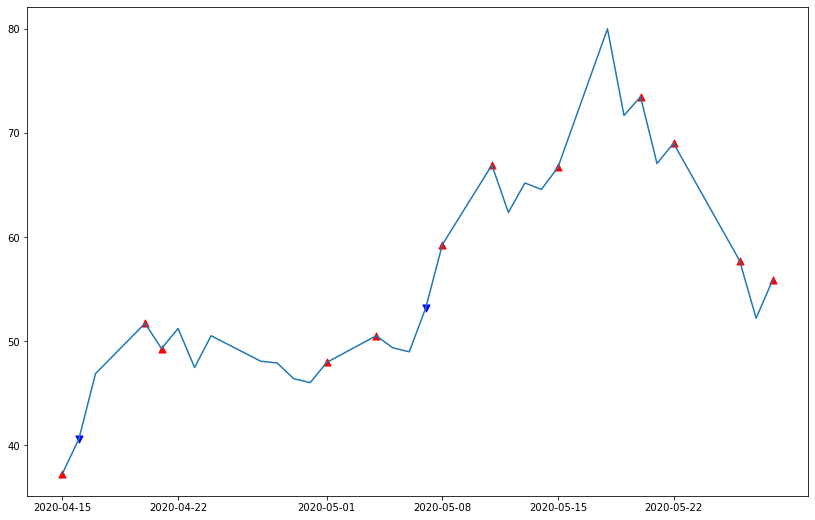

In [28]:

buy_dates = test.loc[test['Action'] ==1].index.values
sell_dates = test.loc[test['Action'] ==2].index.values

buy_close = test.loc[test['Action'] ==1, 'Close'].values
sell_close = test.loc[test['Action'] ==2, 'Close'].values

fig = plt.figure(figsize=(15,9))

plt.plot(test['Close'])
plt.scatter(buy_dates, buy_close, label='skitscat', color='red', s=50, marker="^")
plt.scatter(sell_dates, sell_close, label='skitscat', color='blue', s=50, marker="v")
plt.show()